In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import scipy as sp
import scib
import seaborn as sns
import anndata as ad
scv.logging.print_version()

Running scvelo 0.3.2 (python 3.9.18) on 2024-06-25 23:55.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  #

In [3]:
adata = scv.datasets.pancreas()
adata

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/spliced' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/mnt/nas/user/yixuan/minico

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [4]:
adata.layers['spliced']

<3696x27998 sparse matrix of type '<class 'numpy.float32'>'
	with 9298890 stored elements in Compressed Sparse Row format>

In [5]:
rna=ad.read_h5ad('/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-RNA.h5ad')
atac=ad.read_h5ad('/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-ACTIVE.h5ad')

In [6]:
branch_1=['HSPC','CD8 TEM_2','CD8 TEM_1','CD4 Naive','CD8 Naive','CD4 TCM','CD4 TEM','Naive B','Memory B','Intermediate B','NK','CD16 Mono','CD14 Mono']
rna=rna[rna.obs['cell_type'].isin(branch_1)]
atac=atac[atac.obs['cell_type'].isin(branch_1)]
# emb_branch_1=[]
# count=0
# for e in emb:
#     t=e[e.obs['cell_type'].isin(branch_1)]
#     print(t)
#     count+=1
#     emb_branch_1.append(t)
# print(count)
# emb=emb_branch_1

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [7]:
# 获取索引交集
intersection = atac.var.index.intersection(rna.var.index)

# 打印结果
print(len(intersection),intersection)
rna_intersection = rna[:,intersection]
rna_intersection
atac_intersection = atac[:,intersection]
atac_intersection

5909 Index(['A2M', 'A2M-AS1', 'A2ML1', 'A4GNT', 'AADACL2-AS1', 'AAGAB', 'AASS',
       'AATBC', 'ABAT', 'ABCA1',
       ...
       'ZNRF3', 'ZPLD1', 'ZRANB2-AS2', 'ZRANB3', 'ZSCAN1', 'ZSCAN31',
       'ZSCAN5A', 'ZSWIM3', 'ZSWIM5', 'ZSWIM6'],
      dtype='object', length=5909)


View of AnnData object with n_obs × n_vars = 8911 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'colnames.activity.'

In [8]:
id=4
# sc.pp.pca(multiome_rna)
# sc.pp.neighbors(multiome_rna)
# #sc.tl.draw_graph(rna)
# # sc.pp.neighbors(multiome_rna)
# indices = np.where(np.array(multiome_rna.obs['cell_type'] == 'HSPC'))[0]
#     #rna.uns["iroot"] = np.random.choice(indices)
# multiome_rna.uns["iroot"] = indices[1]

# sc.tl.diffmap(multiome_rna)
# #sc.pp.neighbors(rna,use_rep='X_diffmap')
# sc.tl.dpt(multiome_rna)
indices = np.where(np.array(rna_intersection.obs['cell_type'] == 'HSPC'))[0]
rna_intersection.uns["iroot"] = indices[id]
sc.pp.pca(rna_intersection)
sc.pp.neighbors(rna_intersection)
sc.tl.diffmap(rna_intersection)
sc.tl.dpt(rna_intersection)
# print(rna_intersection.uns['diffmap_evals'].shape)
indices = np.where(np.array(atac_intersection.obs['cell_type'] == 'HSPC'))[0]
atac_intersection.uns["iroot"] = indices[id]
sc.pp.pca(atac_intersection)
sc.pp.neighbors(atac_intersection)
sc.tl.diffmap(atac_intersection)
sc.tl.dpt(atac_intersection)
print(atac_intersection.uns['diffmap_evals'].shape)
obs_index=list(rna.obs.index)
fake_atac_index=[x + '_atac' for x in obs_index]
fake_atac=atac_intersection.copy()
fake_atac.obs['index']=fake_atac_index
fake_atac.obs.set_index('index',inplace=True)
# print('rna',rna.obs)
# multiome_rna = ad.concat([rna, fake_atac])
multiome_rna = ad.concat([rna_intersection, fake_atac])
multiome_rna.uns["iroot"] = indices[id]
print(indices)

/tmp/ipykernel_27859/3789518928.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  rna_intersection.uns["iroot"] = indices[id]
/tmp/ipykernel_27859/3789518928.py:21: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  atac_intersection.uns["iroot"] = indices[id]


(15,)
[ 466 2537 3899 3958 5014 5886 6175 6915 7248 7285 7359 7587 7701 8289
 8449 8731 8750]


In [9]:
temp_rna_diff=rna_intersection.uns['diffmap_evals']
temp_atac_diff=atac_intersection.uns['diffmap_evals']
temp_diff=(temp_atac_diff+temp_rna_diff)/2
multiome_rna.uns['diffmap_evals']=temp_diff
temp_dic=rna_intersection.uns['neighbors']
multiome_rna.uns['neighbors']=temp_dic

In [10]:
multiome_rna

AnnData object with n_obs × n_vars = 17822 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    uns: 'iroot', 'diffmap_evals', 'neighbors'
    obsm: 'X_pca', 'X_diffmap'

In [11]:
scv.tl.velocity(multiome_rna)
scv.tl.velocity_graph(multiome_rna)

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities


KeyError: 'Ms'

ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

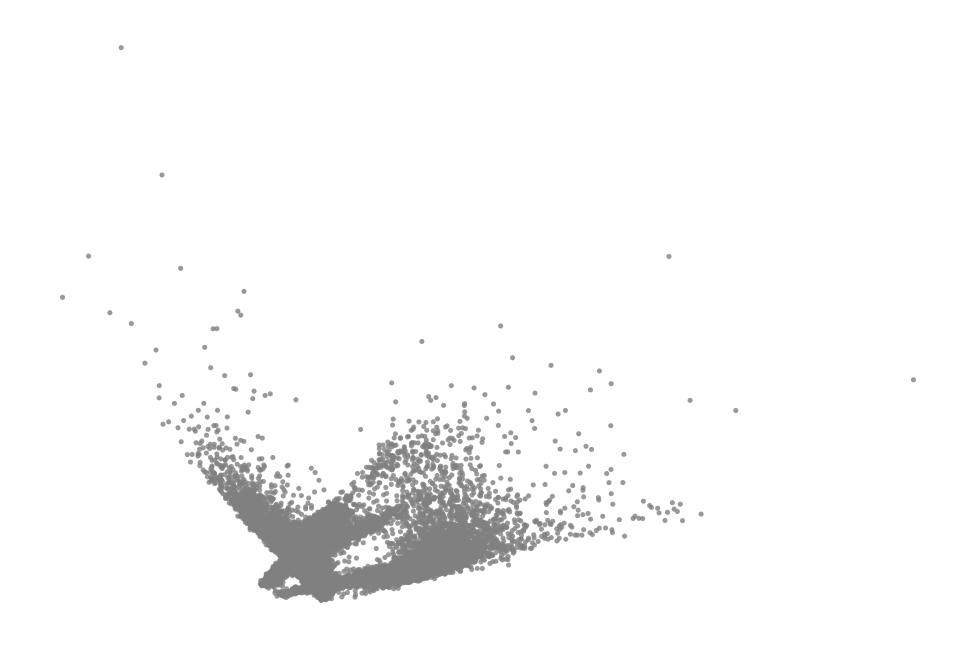

In [23]:
scv.pl.velocity_graph(multiome_rna, threshold=.1)

In [8]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs

In [25]:
scv.pp.filter_and_normalize(multiome_rna, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(multiome_rna, n_pcs=30, n_neighbors=30)

KeyError: 'spliced'

In [26]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

computing velocity embedding


KeyError: 'velocity'

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


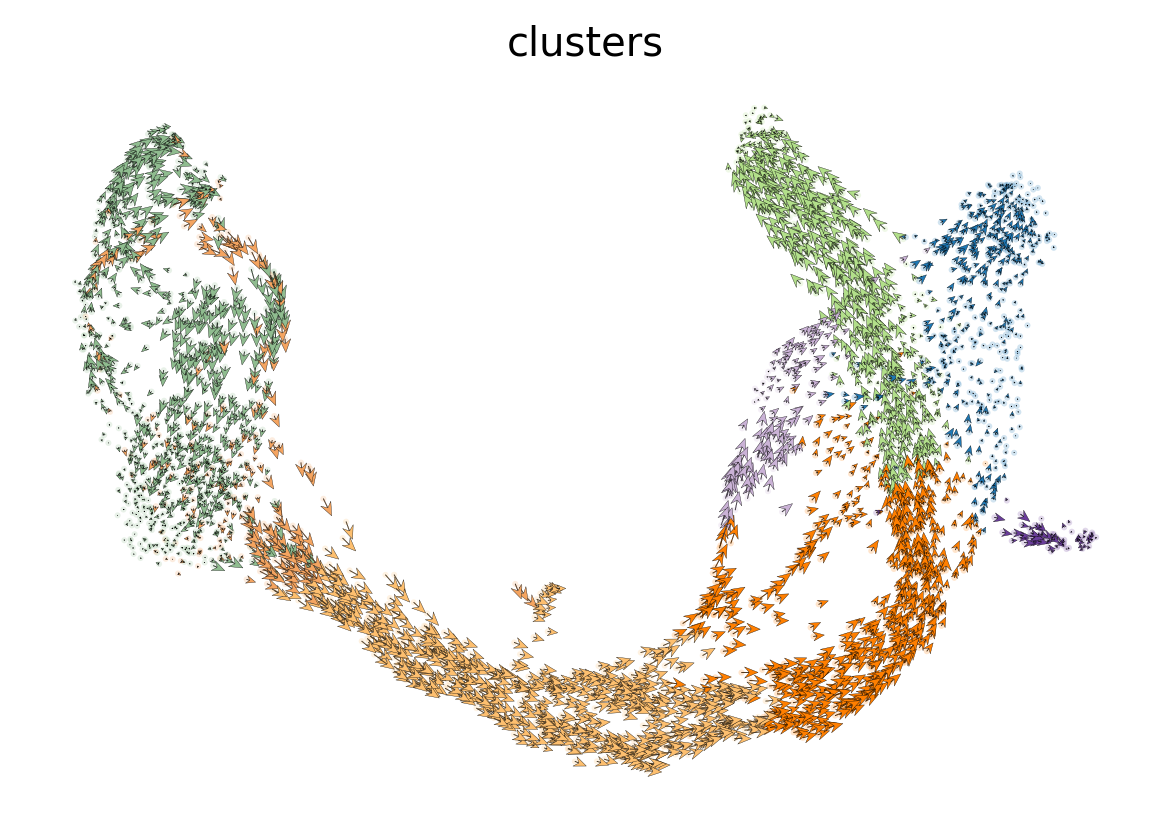

In [11]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

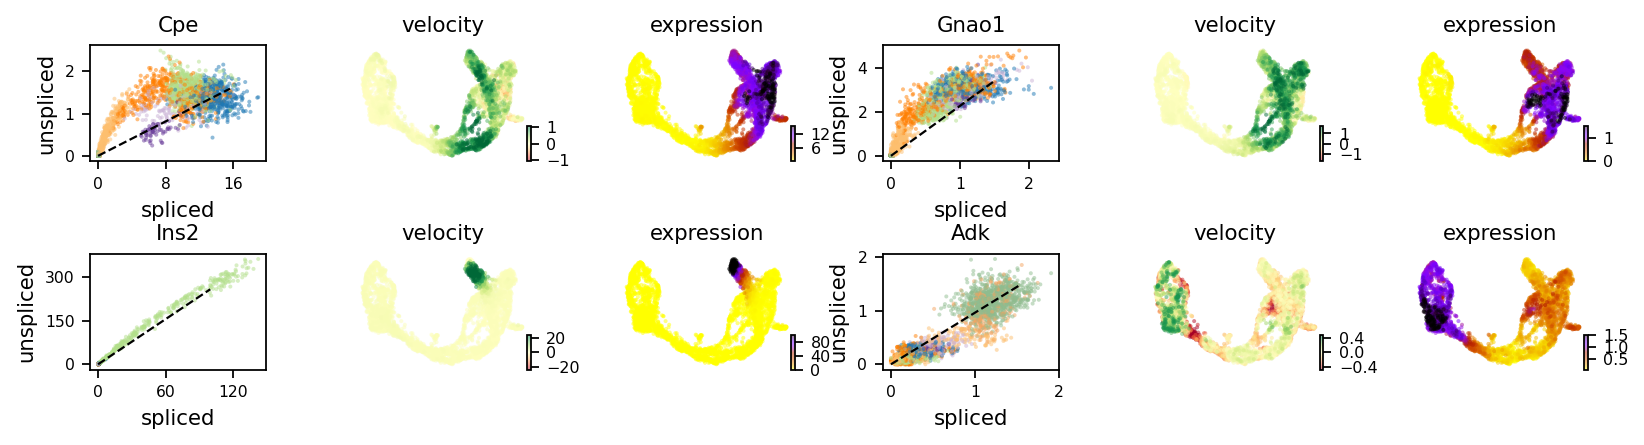

In [12]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


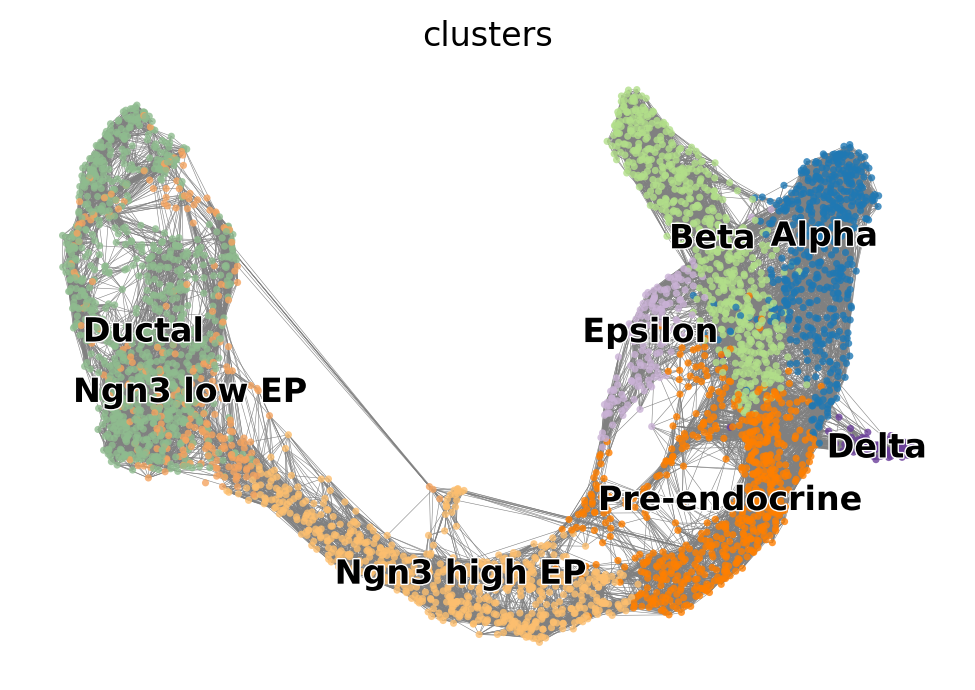

In [13]:
scv.pl.velocity_graph(adata, threshold=.1)

In [12]:
scv.tl.velocity_pseudotime(multiome_rna)
scv.pl.scatter(multiome_rna, color='velocity_pseudotime', cmap='gnuplot')

computing terminal states


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

In [13]:
multiome_rna

AnnData object with n_obs × n_vars = 17822 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    uns: 'iroot', 'diffmap_evals', 'neighbors'
    obsm: 'X_pca', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [14]:
# this is needed due to a current bug - bugfix is coming soon.
multiome_rna.uns['neighbors']['distances'] = multiome_rna.obsp['distances']
multiome_rna.uns['neighbors']['connectivities'] = multiome_rna.obsp['connectivities']

In [15]:
scv.tl.paga(multiome_rna, groups='clusters')
df = scv.get_df(multiome_rna, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

In [24]:
scv.pl.paga(multiome_rna, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

KeyError: 'paga'